# Learning Seattle's Work Habits from Bicycle Counts
# 透過自行車流量認識西雅圖上班族工作習慣


#### 以下範例將分成兩部分進行：
#### 第一部分以 2012/10/03~2015/12/31的資料開始分析(與原文作者，使用的時間區間相近)
#### 第二部分以 2016/01/01~2019/05/27進行與第一部分比較分析，討論自行車使用習慣的逐年變化。
-------------------------------------------------------

# 第二部分：
# 使用2016/01/01~2019/06/30 資料與第一部分進行比較
## 先進行與第一部分相同的處理，再針對不同的結果作比較
------------------------------------------
## The Data 資料說明、初步觀察

<!-- PELICAN_BEGIN_SUMMARY -->
資料使用西雅圖的佛里蒙特橋([Fremont Bridge](http://www.openstreetmap.org/#map=17/47.64813/-122.34965).)每小時單車流量。

此資料來自於，2012年下半年安裝在佛里蒙特橋的自動自行車計數器，感應器裝置設置在東西兩側通行道。

資料檔案，從官方資料庫下載[西雅圖的佛里蒙特橋每小時自行車流量](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k)

使用 [pandas](http://pandas.pydata.org) 函式庫載入資料 : 

In [34]:
import pandas as pd
data = pd.read_csv('fremont-bridge-hourly-bicycle-counts-by-month-october-2012-to-present.csv',
                   index_col='Date', parse_dates=True)
# index_col='Date' 直接使用資料中的'Date'欄位，做為每筆資料的索引。
# parse_dates=True 嘗試將所有可能的數據解析為時間格式，之後可以直接使用時間對資料做操作。
data.head()

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2019-01-01 00:00:00,0.0,9.0
2019-01-01 01:00:00,2.0,22.0
2019-01-01 02:00:00,1.0,11.0
2019-01-01 03:00:00,1.0,2.0
2019-01-01 04:00:00,2.0,1.0


初步的整理資料: 將欄位名稱重新命名，簡化成 "West" 和 "East"。將所有缺失值補0，並新增 "Total" 欄位，表達總流量:

In [35]:
data.columns = ['West', 'East'] # 指定新的欄位名稱
data.fillna(0, inplace=True) # 填補缺失值(NaN)
data['Total'] = data.eval('East + West') # 新增欄位Total，為East、West的總和

選取特定時間區間，mask設定**2016/01/01-2019/06/30**

In [36]:
mask = (data.index >= '2016-01-01') & (data.index <= '2019-06-30')
# 用來選取時間區間的遮罩

data = data.iloc[mask]
data.head()

,West,East,Total
Date,,,
2019-01-01 00:00:00,0.0,9.0,9.0
2019-01-01 01:00:00,2.0,22.0,24.0
2019-01-01 02:00:00,1.0,11.0,12.0
2019-01-01 03:00:00,1.0,2.0,3.0
2019-01-01 04:00:00,2.0,1.0,3.0


使用簡單的視覺化呈現，可以對整體資料有初步掌握。

以下做法，調整資料時間頻率，改為一週一筆數據，單筆數據為單週自行車流量的總和。改變資料密度，再視覺化調整後的資料 :

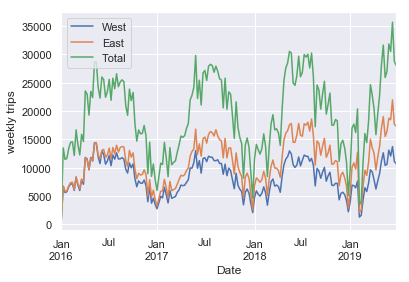

In [37]:
# 先匯入基本函式庫
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # 設定圖表樣式
import numpy as np

data.resample('W').sum().plot() # 透過resample函式，調整資料，再畫出圖表
# 'W':表示將時間頻率轉換為一星期(week)，sum():轉變時間頻率後的操作，設定為總和

plt.ylabel('weekly trips'); # y軸標籤

從整體圖表可以看出自行車流量有明顯的季節性變化

## Extracting Knowledge from the Data 從資料中提取資訊

在做分析時，我們可以以直覺做出推斷，推測自行車流量可能受到那些因素(如天氣、時序)影響，再將推測以程式碼驗證。

但本文的做法則是讓資料自己告訴我們它隱含了哪些資訊，並採取*非監督式(unsupervised)學習*的方式，去學習資料所要告訴我們的資訊。

我們先將每天資料視為獨立個體，每天我們有48個觀測值：東西兩側通行道，各24小時的監測資料。

根據這些觀測值，謹慎的推斷這些日子所隱藏的資訊，我們應該能夠不依靠任何假設，就從資料提取出有意義的量化描述及資訊。

## Transforming the Data 資料呈現方式轉換

將資料轉換成一個二維矩陣，每一列(row)代表一天，欄(column)則表示一天中的48個監測數據。

使用pandas中的``pivot_table()`` 函式可以為我們做到上述的轉換動作。

data中的"East" 和"West" 欄位是我們需要的數據，以日期作為列索引，以當天的每一小時作為欄索引，將資料重新配置。

所有的缺失值則以補0處理 :

In [38]:
pivoted = data.pivot_table(['East', 'West'],
                           index=data.index.date, # data中的索引取日期(date)的部分當作pivoted 的列索引
                           columns=data.index.hour, # data中的索引取小時(hour) 當作pivoted 的欄索引
                           fill_value=0)
pivoted.head()

East                                   ... West                   \
Date         0   1  2  3  4  5   6   7    8   9   ...   14  15  16   17  18   
2016-01-01    9  12  5  6  2  2   1   2    9   9  ...   57  36  30   14   8   
2016-01-02    1   0  0  0  2  1   4   5   10  15  ...   60  48  35   17   7   
2016-01-03    0   2  1  1  0  2   5   7   10  19  ...   19  16  14    9   7   
2016-01-04    0   0  0  1  3  8  29  49  101  53  ...   15  19  54   96  69   
2016-01-05    0   0  0  0  3  9  27  67   93  57  ...   12  23  55  101  64   

                             
Date        19  20 21 22 23  
2016-01-01   6   5  6  3  3  
2016-01-02   8   5  0  6  3  
2016-01-03   4   5  2  2  1  
2016-01-04  21  13  9  5  1  
2016-01-05  27  13  9  7  3  

[5 rows x 48 columns]

下一步我們提取原數據，將它們轉為矩陣型態:

In [39]:
X = pivoted.values # 建立 X 物件，將 pivoted的值轉存成矩陣型態
X.shape # 查看矩陣大小

(1277, 48)

可以看出我們的資料天數有兩千多天，每天則包含上述的48筆測量值。

## Visualizing the Data 視覺化資料

我們可以將資料視為1185個存在於*48-維*空間的不同物件: 每一個維度的值代表 某一側自行車通行道，某一小時測量的自行車流量。

將48維度的資料視覺化是相當困難的，因此我們要使用一個通用降維度(*dimensionality reduction*)的技術，讓資料維度數下降成更容易掌握的大小。

這裡要使用的是[主成分分析(PCA, Principal Component Analysis)](http://scikit-learn.org/stable/modules/decomposition.html)，是一種統計分析、簡化數據集的方法。經過數學線性代數的線性投影(linear projection)，旋轉資料在向量空間中的座標軸，讓投影結果能夠保留最大變異數。

下面的做法，我們先設定保留至少90%的變異數 : 

In [40]:
from sklearn.decomposition import PCA # 匯入PCA函式庫
pca = PCA(0.9) # 建立pca模型，設定保留至少90%的變異數

Xpca = pca.fit_transform(X) # X放入pca模型進行轉換

pca.explained_variance_ratio_ # 查看90%的變異數中各成分佔的比例

array([0.85865353, 0.06576331])

設定保留至少90%的變異數，得到兩個成分，其中第一主成分佔了約85%的變異數，而第二主成分則佔了約6.5%的資料，
表示將原始資料經過PCA處理後，得到一個2維的資訊。

48維度資料很難以圖片表達，但2維度資料，則能以我們所知的方式畫出資料分布：

畫一個點散佈圖，並以當日總自行車流量為每一點上色做為參照:

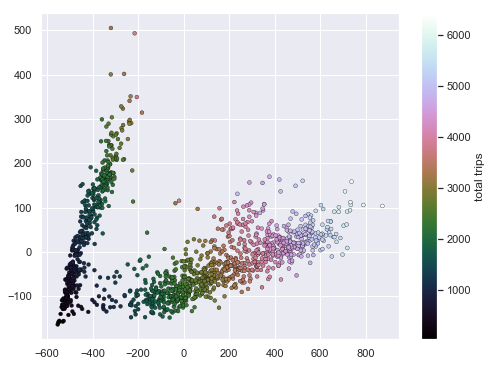

In [41]:
total_trips = X.sum(1) # 每一日總流量 為X的第二維資料(一天中的48個觀測值)的總和

plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0],Xpca[:, 1], c=total_trips,
            s=15, cmap='cubehelix', edgecolors='black',linewidths=0.3)
# 參數說明：c=上色依據的數值，cmap=色彩對應表，edgecolors=點的邊框顏色，linewidths=邊框大小

plt.colorbar(label='total trips')

根據圖表，資料被區分成明顯的兩群，且自行車總流量隨著各群體的分布長軸漸增。此外，兩個群體的分界線在總流量的很低時，較不明顯。

以原始資料(僅經過排序處理)所畫的分布圖看來，可以推論出每日的自行車騎乘模式，主要有兩種型態。後續將繼續型塑這些集群，釐清這兩種型態的日子真正的差別是什麼。

## Unsupervised Clustering 非監督式聚類分析

當你有一群資料，你希望它們能夠在"不決定要分成哪些類別"的前提下自行分群，那麼你就需要*聚類分析(clustering)* 演算法的幫助。

聚類分析演算法的種類很多，但對於上面資料呈現明確的橢圓分布，[高斯混合模型Gaussian Mixture Models](http://scikit-learn.org/stable/modules/mixture.html) 非常符合我們的需求。

我們將再次透過scikit-learn使用高斯混合模型計算資料，並依據模型預測的聚類(分群)標籤，畫出圖表：

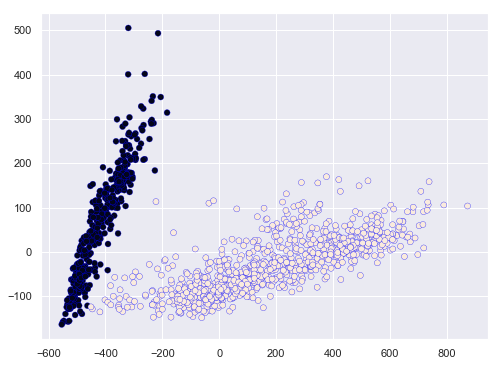

In [42]:
from sklearn.mixture import GaussianMixture # 匯入高斯混合模型函式庫
gmm = GaussianMixture(2, covariance_type='full', random_state=0) # 建立模型，2 表示分群標籤數
# covariance_type=估計各類別時，約束共變異數的方式

gmm.fit(Xpca) # 訓練模型
cluster_label = gmm.predict(Xpca) # 預測結果

plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=cluster_label, edgecolors='blue',linewidths=0.3)
# c=上色依據的數值，edgecolors=點的邊框顏色，linewidths=邊框大小

之前PCA處理分好的兩個群體被塗上不同顏色，表示高斯混合模型所算出來幫資料分類的標籤，和前面分好的群體，分類的依據是相符的。
接下來我們要將推測出的兩個聚類標籤加入最初的數據集：

In [43]:
pivoted['Cluster'] = cluster_label # 在pivoted新增欄位:聚類標籤
data = data.join(pivoted['Cluster'], on=data.index.date) # 將pivoted新增的'Cluster'，依據時間索引轉貼回最初的data
data.head()

,West,East,Total,Cluster
Date,,,,
2019-01-01 00:00:00,0.0,9.0,9.0,0
2019-01-01 01:00:00,2.0,22.0,24.0,0
2019-01-01 02:00:00,1.0,11.0,12.0,0
2019-01-01 03:00:00,1.0,2.0,3.0,0
2019-01-01 04:00:00,2.0,1.0,3.0,0


我們讓每筆資料都被貼上分群後的標籤。
接下來，使用groupby函式，在更新後的數據集中，找出聚類、時間的平均值趨勢:

In [44]:
by_hour = data.groupby(['Cluster', data.index.time]).mean() # 將資料依據兩個cluster、一天中的24小時分群後，計算平均值
# 一個row表示 聚類0/1在 所有日期的某個時間整點 平均自行車流量為何
by_hour.head()

West      East      Total
Cluster                                        
0       00:00:00  5.957286  8.402010  14.359296
        01:00:00  3.506297  4.571788   8.078086
        02:00:00  2.216625  2.591940   4.808564
        03:00:00  1.138539  1.614610   2.753149
        04:00:00  1.375315  2.357683   3.732997

最後，畫出兩個cluster資料，在一天當中每小時平均自行車流量趨勢圖：

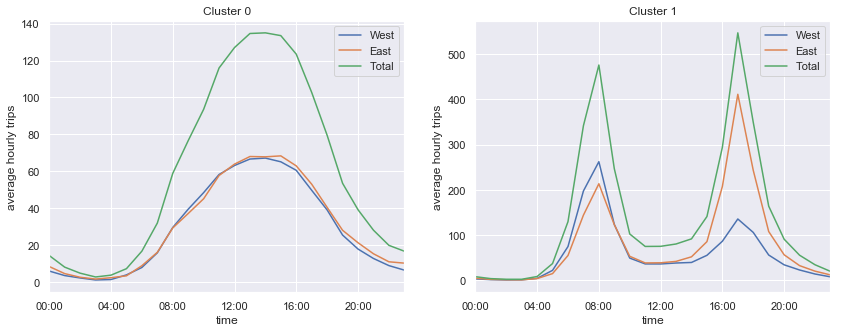

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5)) # 1,2表示分別畫出兩個圖表
hourly_ticks = 4 * 60 * 60 * np.arange(6) # 以小時做為刻度，之後做為X軸

for i in range(2):
    by_hour.loc[i].plot(ax=ax[i], xticks=hourly_ticks) # 分別取cluster 0/1
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')

第二部分這邊將自行車流量隨時間推移呈現較寬的單峰分布的群編號為0，呈現兩個尖峰分布編號為1。

### 單峰分布的圖可以看到，比起第一部分的時間區間，近年的東西側通行道流量非常接近。
### 雙峰分布的圖，被推論為上班導向的分布，但在上午八點的高峰時段東西側通行道的流量，相較第一部分，更加接近。
### 造成這樣的區別的可能因素很多，可以猜測西雅圖佛蒙特橋的兩端區域發展越來越接近，鬧區郊區的關係比起早年，稍微更模糊，但實際原因需要搜尋更多的資訊，或其他的資料分析去驗證。

## Seattle's Work Habits 西雅圖地區的工作習慣

我們得到的兩個類別，第一個類別(Cluster 0)代表了非工作日(週六、日)，第二個類別(Cluster 1)屬於上班日(週一到週五)。
再次畫出我們用來推測類別的資料(一筆資料代表一天)分布圖，並且以星期一~星期日為每筆資料上色：

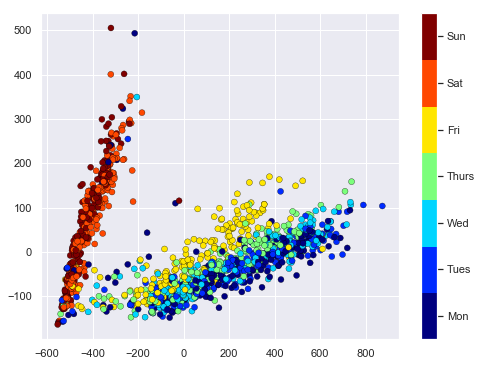

In [46]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
# 以dayofweek 表示 原本pivoted的索引(日期)，轉換回傳成以星期(dayofweek)表示的索引。

plt.figure(figsize=(8, 6))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=dayofweek,
            cmap=plt.cm.get_cmap('jet', 7), edgecolors='black',linewidths=0.3)
# cmap以'jet'當作色彩對應，並間隔取出7個顏色

cb = plt.colorbar(ticks=range(7)) # 畫上色彩圖例
cb.set_ticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.clim(-0.5, 6.5); # 限制色彩範圍

可以從上圖看出和第一部分相似的結果，平日/周末的直覺猜測大致上是對的，但有一點例外：**少數的平日出現在推測為非上班日型態的那一群之中**，星期五的分布也比其他平日更靠近非上班日的群體。

我們將仔細檢視少數落在"錯誤"群體的"特殊的"平日。
前置動作，建立一個data frame，列出每天的類別標籤以及是星期幾：

In [47]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)  # '%a'表示顯示 星期的縮寫
results.head()

,cluster,is_weekend,weekday
2016-01-01,0,False,Fri
2016-01-02,0,True,Sat
2016-01-03,0,True,Sun
2016-01-04,1,False,Mon
2016-01-05,1,False,Tue


首先，我們先查看多少星期六、日是落在通勤導向的群體中。

In [48]:
weekend_workdays = results.query('cluster == 1 and is_weekend')
len(weekend_workdays)

2

### 得出 2016/01/01~2019/06/30這個時間區間中，有兩天周末日，被歸類在上班日分布。
### 看看是哪兩天：

In [49]:
weekend_workdays

,cluster,is_weekend,weekday
2018-06-16,1,True,Sat
2019-02-03,1,True,Sun


畫出它們的當日流量分布：

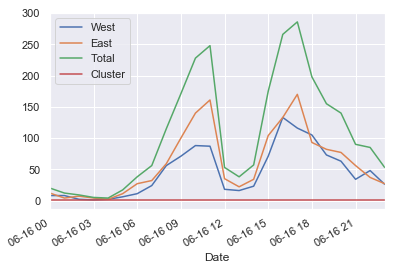

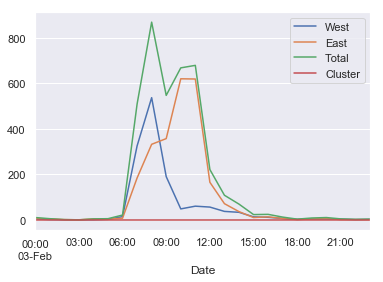

In [50]:
data.loc['2018-06-16'].plot();
data.loc['2019-02-03'].plot();

### 畫出這兩天的當日流量趨勢圖後，並沒有我們所知的特徵能看出這兩天屬於哪一類別，推測是PCA的主成分不完全是以上班日、假日的特徵去分析資料，需要以其他演算法進行分析。
### 也表示第一、二部分都是屬於整體資料的分析，並還未考慮個別資料。

接下來查看有多少平日落在假日導向的群體中：

In [51]:
midweek_holidays = results.query('cluster == 0 and not is_weekend') # 符合條件(星期一~五，但落在假日導向的群體中)的列
len(midweek_holidays)

34

**2016/01/01~2019/06/30**這個時間區間中有34天平日，西雅圖的單車族整體看來沒有去上班。
我們載入Pandas內建的美國國定假日日曆來標記這些資料：

In [52]:
from pandas.tseries.holiday import USFederalHolidayCalendar # 匯入美國國定假日日曆

cal = USFederalHolidayCalendar()
holidays = cal.holidays('2016', '2020', return_name=True) # 需將結尾設定成2020，才會包含2019整年的節日
holidays.head()

2016-01-01                 New Years Day
2016-01-18    Dr. Martin Luther King Jr.
2016-02-15                Presidents Day
2016-05-30                   MemorialDay
2016-07-04                      July 4th
dtype: object

為了完整性，將這些節日的前後一天也加入列表中：

In [53]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2015-12-31                 Day Before New Years Day
2016-01-01                            New Years Day
2016-01-02                  Day After New Years Day
2016-01-17    Day Before Dr. Martin Luther King Jr.
2016-01-18               Dr. Martin Luther King Jr.
dtype: object

使用的是美國的*observed* holidays(當年節日如果落在六，則將其提前一天，改在星期五；落在星期日，則延後一天為星期一)
有了以上的整理的資料及了解後，我們可以繼續探討上班日，但西雅圖自行車通勤族，選擇待在家的原因為何：

In [54]:
holidays_all.name = 'name'  # 執行 join 所需要
joined = midweek_holidays.join(holidays_all) 
# 使用join將國定假日清單，根據日期，加到對應的 前面取得的 midweek_holidays(屬於平日，但落在假日導向的群體中的日子)
set(joined['name']) # 取得欄位'name'的集合，看到'推測的星期一到五休假日'的種類有哪些

{'Christmas',
 'Day After Christmas',
 'Day After Thanksgiving',
 'Day Before Christmas',
 'Day Before New Years Day',
 'July 4th',
 'Labor Day',
 'MemorialDay',
 'New Years Day',
 'Thanksgiving',
 nan}

### 和第一部分不同的地方，第二部分出現nan值，表示有 無法以國定假日解釋的 *平日，但落在假日導向的群體中的日子*
### 下面列出出現nan的日期：

In [55]:
joined[joined.isnull().any(axis=1)] # 列出nan 的日期

,cluster,is_weekend,weekday,name
2016-12-23,0,False,Fri,NaN
2016-12-30,0,False,Fri,NaN
2017-02-06,0,False,Mon,NaN
2019-02-04,0,False,Mon,NaN
2019-02-05,0,False,Tue,NaN
2019-02-08,0,False,Fri,NaN
2019-02-11,0,False,Mon,NaN
2019-02-12,0,False,Tue,NaN


### 可以針對這些日子，個別在網路上進行搜尋發生什麼事，使得除了國定假日以外，某些平日也不需要上班，
### 2019二月多天的假期，經過網路搜尋後，可能為該地區罕見的強降雪導致臨時放假[(新聞連結)](http://www.epochtimes.com/b5/19/2/14/n11043748.htm)。

另一方面， 以下是國定放假的節日，但西雅圖自行車通勤族會選擇去上班：

In [56]:
set(holidays) - set(joined.name)

{'Columbus Day',
 'Dr. Martin Luther King Jr.',
 'Presidents Day',
 'Veterans Day'}

## Update: What's up with Fridays? 特別的星期五

與第一部分，針對星期五的離群值，同樣先將星期五在圖上做特別標記，更清楚看出分布：

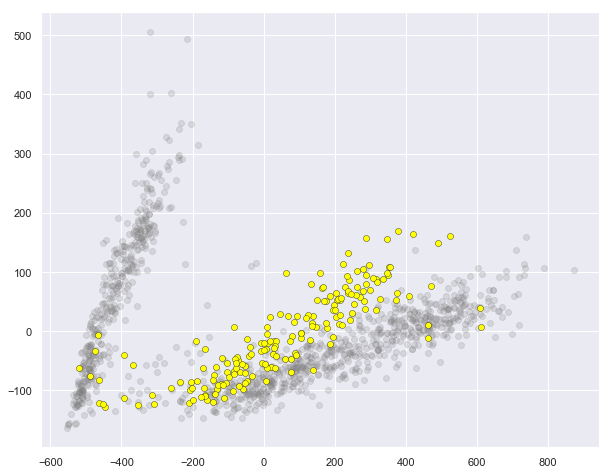

In [57]:
fridays = (dayofweek == 4)

plt.figure(figsize=(10, 8))
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2) # 全部先塗上淡灰色
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow', edgecolors='black',linewidths=0.3); # 星期五塗上黃色

### 與第一部分不同的是，右下角的星期五'離群值'沒有這麼明顯了，與其他的上班日區別也消失了
### 先將與其他星期五趨勢不同的星期五取出來，查看分是哪些日子：

In [58]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 0] > 450) & (Xpca[:, 1] < 50)]
weird_fridays

Index([2016-05-20, 2017-05-19, 2018-05-18, 2019-05-17], dtype='object')

和第一部分一樣，每筆資料也是出現在每年的五月中。

接來簡單的畫出，他們的當日流量狀態，並加上全體的平均流量。

我們可以利用pivot_table達成以上操作：

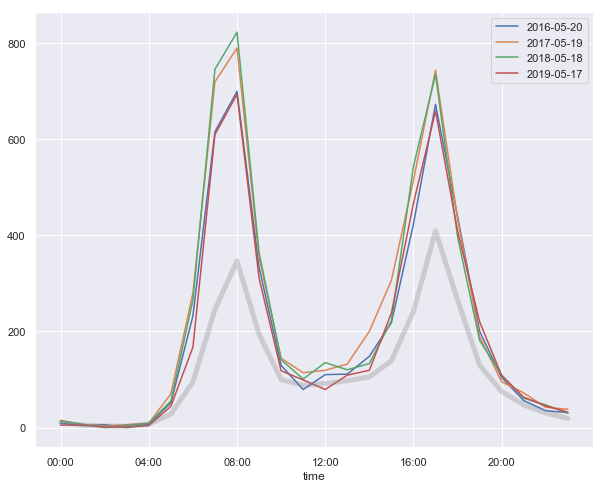

In [59]:
all_days = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
# 建立命名為 all_day的 pivot_tabel，放置原資料data中的total欄位，以24小時作為列索引，所有日期作為欄索引

plt.figure(figsize=(10, 8))
plt.plot(all_days.loc[:, weird_fridays]); # 取出weird_fridays畫圖

plt.plot(all_days.mean(1), color='gray', lw=5, alpha=0.3) # 畫平均值
# all_days.mean(1) 計算每行(每小時)的平均值
plt.legend(weird_fridays) # 畫上圖列，顯示那三天的日期
plt.xticks(hourly_ticks);

### 第一部分得到的三天，發現它們是西雅圖一年一度的[bike to work day](http://www.cascade.org/f5-bike-work-day)。
### 第二部分的這四天也可以得到相同結果，但是與其他的上班日區別消失，可推斷是近年騎自行車的風氣越來越盛行，特別號召的自行車上班日，在整體來看，流量沒有特別高。
### 以下為兩部分的總自行車流量圖，查看近幾年流量是否增加的趨勢：

Text(0, 0.5, 'weekly trips')

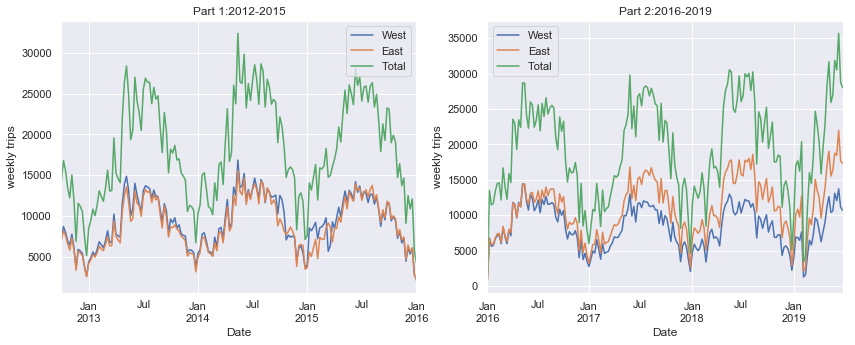

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5)) # 1,2表示分別畫出兩個圖表

# 兩個時間遮罩
mask0 = (data.index >= '2012-10-03') & (data.index <= '2015-12-31')
mask1 = (data.index >= '2016-01-01') & (data.index <= '2019-06-30')
# 選取時間
data0 = data.iloc[mask0]
data1 = data.iloc[mask1]

# 畫圖
data0.resample('W').sum().plot(ax=ax[0]) # 透過resample函式，調整資料，再畫出圖表
ax[0].set_title('Part 1:2012-2015')
ax[0].set_ylabel('weekly trips') # y軸標籤
                
data1.resample('W').sum().plot(ax=ax[1]) 
ax[1].set_title('Part 2:2016-2019')
ax[1].set_ylabel('weekly trips')

## 第二部分總結

以相同的分析，處理不同的時間區間，發現結果會有不同，反應了趨勢會隨時間改變外，在做資料分析時的分析方式(使用的演算法)，也需要考慮作出改變。